<a href="https://colab.research.google.com/github/gitnicolas343/ejerciciosTAM-/blob/main/ejercicios_14_feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Función para agregar ruido gaussiano
def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(scale=np.sqrt(noise_power), size=images.shape)
    return np.clip(images + noise, 0, 1)

# Función corregida para agregar ruido sal y pimienta
def add_salt_and_pepper_noise(images, amount=0.02):
    noisy_images = images.copy()
    num_pixels = int(amount * images.shape[1] * images.shape[2])  # Píxeles a modificar

    for img in noisy_images:
        # Generar coordenadas aleatorias
        coords = [np.random.randint(0, i, num_pixels) for i in img.shape]
        img[coords[0], coords[1]] = np.random.choice([0, 1])  # Sal o pimienta
    return noisy_images

# Cargar datos Fashion MNIST
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000] / 255.0, X_train_full[-5000:] / 255.0
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Agregar dimensión de canal
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Generar datos con ruido
X_train_gaussian = add_gaussian_noise(X_train, snr_db=3)
X_train_sp = add_salt_and_pepper_noise(X_train, amount=0.02)
X_valid_gaussian = add_gaussian_noise(X_valid, snr_db=3)
X_valid_sp = add_salt_and_pepper_noise(X_valid, amount=0.02)

# Definir etiquetas de género
gender_labels = {
    0: 2,  # T-shirt/top → Unisex
    1: 2,  # Trouser → Unisex
    2: 0,  # Pullover → Masculino
    3: 1,  # Dress → Femenino
    4: 0,  # Coat → Masculino
    5: 1,  # Sandal → Femenino
    6: 0,  # Shirt → Masculino
    7: 2,  # Sneaker → Unisex
    8: 1,  # Bag → Femenino
    9: 2   # Ankle boot → Unisex
}

# Crear etiquetas de género
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_valid_gender = np.array([gender_labels[label] for label in y_valid])

# Definir entradas
input_clean = keras.Input(shape=(28, 28, 1), name="input_clean")
input_gaussian = keras.Input(shape=(28, 28, 1), name="input_gaussian")
input_sp = keras.Input(shape=(28, 28, 1), name="input_sp")

# Autoencoder
def autoencoder_block(input_layer):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return encoded

encoded_clean = autoencoder_block(input_clean)
encoded_gaussian = autoencoder_block(input_gaussian)
encoded_sp = autoencoder_block(input_sp)

# Fusionar características
merged = layers.Concatenate()([encoded_clean, encoded_gaussian, encoded_sp])

# Clasificación con CNN
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merged)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Salidas
output_class = layers.Dense(10, activation='softmax', name="output_class")(x)
output_gender = layers.Dense(3, activation='softmax', name="output_gender")(x)

# Modelo
model = keras.Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[output_class, output_gender])

# Compilar modelo
# Compilar modelo corregido
model.compile(
    optimizer='adam',
    loss={'output_class': 'sparse_categorical_crossentropy', 'output_gender': 'sparse_categorical_crossentropy'},
    metrics={'output_class': ['accuracy'], 'output_gender': ['accuracy']}
)

# Resumen del modelo
model.summary()

# Preparar datos de entrada y salida
X_train_inputs = [X_train, X_train_gaussian, X_train_sp]
X_valid_inputs = [X_valid, X_valid_gaussian, X_valid_sp]

y_train_outputs = {"output_class": y_train, "output_gender": y_train_gender}
y_valid_outputs = {"output_class": y_valid, "output_gender": y_valid_gender}

# Verificar formas antes de entrenar
print("Shapes de las entradas:")
print("X_train:", X_train.shape, "X_train_gaussian:", X_train_gaussian.shape, "X_train_sp:", X_train_sp.shape)
print("Shapes de las salidas:")
print("y_train:", y_train.shape, "y_train_gender:", y_train_gender.shape)

# Entrenar el modelo
history = model.fit(
    X_train_inputs, y_train_outputs,
    validation_data=(X_valid_inputs, y_valid_outputs),
    epochs=20,
    batch_size=64
)

# Evaluación
X_test_gaussian = add_gaussian_noise(X_test, snr_db=3)
X_test_sp = add_salt_and_pepper_noise(X_test, amount=0.02)
y_test_gender = np.array([gender_labels[label] for label in y_test])

X_test_inputs = [X_test, X_test_gaussian, X_test_sp]
y_test_outputs = {"output_class": y_test, "output_gender": y_test_gender}

# Evaluar el modelo en los datos de prueba
results = model.evaluate(X_test_inputs, y_test_outputs)

# Imprimir los resultados
print(f"Total Loss: {results[0]:.4f}")
print(f"Loss - Prenda: {results[1]:.4f}, Loss - Género: {results[2]:.4f}")
print(f"Accuracy - Prenda: {results[3]:.4f}, Accuracy - Género: {results[4]:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_clean (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gaussian            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sp (InputLayer)     │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_clean[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_gaussian[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_sp[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 14, 14, 32)     │              0 │ conv2d_14[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 14, 14, 32)     │              0 │ conv2d_16[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 14, 14, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_14[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_13          │ (None, 7, 7, 64)       │              0 │ conv2d_15[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 7, 7, 64)       │              0 │ conv2d_17[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_17          │ (None, 7, 7, 64)       │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 7, 7, 192)      │              0 │ max_pooling2d_13[0][0… │
│ (Concatenate)        

 Total params: 1,082,381 (4.13 MB)

 Trainable params: 1,082,381 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

Shapes de las entradas:
X_train: (55000, 28, 28, 1) X_train_gaussian: (55000, 28, 28, 1) X_train_sp: (55000, 28, 28, 1)
Shapes de las salidas:
y_train: (55000,) y_train_gender: (55000,)
Epoch 1/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 1.0002 - output_class_accuracy: 0.7545 - output_class_loss: 0.6653 - output_gender_accuracy: 0.8612 - output_gender_loss: 0.3349 - val_loss: 0.4712 - val_output_class_accuracy: 0.8814 - val_output_class_loss: 0.3164 - val_output_gender_accuracy: 0.9386 - val_output_gender_loss: 0.1517
Epoch 2/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.4397 - output_class_accuracy: 0.8942 - output_class_loss: 0.2948 - output_gender_accuracy: 0.9438 - output_gender_loss: 0.1449 - val_loss: 0.3909 - val_output_class_accuracy: 0.9030 - val_output_class_loss: 0.2613 - val_output_gender_accuracy: 0.9496 - val_output_gender_loss: 0.1257
Epoch 3/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3552 - output_class_accuracy: 0.9117 - output_class_loss:

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(scale=np.sqrt(noise_power), size=images.shape)
    return np.clip(images + noise, 0, 1)

def add_salt_and_pepper_noise(images, amount=0.02):
    noisy_images = images.copy()
    num_pixels = int(amount * images.shape[1] * images.shape[2])
    for img in noisy_images:
        coords = [np.random.randint(0, i, num_pixels) for i in img.shape]
        img[coords[0], coords[1]] = np.random.choice([0, 1])
    return noisy_images

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000] / 255.0, X_train_full[-5000:] / 255.0
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train_gaussian = add_gaussian_noise(X_train, snr_db=3)
X_train_sp = add_salt_and_pepper_noise(X_train, amount=0.02)
X_valid_gaussian = add_gaussian_noise(X_valid, snr_db=3)
X_valid_sp = add_salt_and_pepper_noise(X_valid, amount=0.02)

gender_labels = {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 2, 8: 1, 9: 2}
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_valid_gender = np.array([gender_labels[label] for label in y_valid])

input_clean = keras.Input(shape=(28, 28, 1), name="input_clean")
input_gaussian = keras.Input(shape=(28, 28, 1), name="input_gaussian")
input_sp = keras.Input(shape=(28, 28, 1), name="input_sp")

def autoencoder_block(input_layer):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return encoded

encoded_clean = autoencoder_block(input_clean)
encoded_gaussian = autoencoder_block(input_gaussian)
encoded_sp = autoencoder_block(input_sp)

merged = layers.Concatenate()([encoded_clean, encoded_gaussian, encoded_sp])

def decoder_block(encoded_input):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output_reconstructed")(x)
    return decoded

output_reconstructed = decoder_block(merged)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merged)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

output_class = layers.Dense(10, activation='softmax', name="output_class")(x)
output_gender = layers.Dense(3, activation='softmax', name="output_gender")(x)

model = keras.Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[output_class, output_gender, output_reconstructed])

model.compile(optimizer='adam',
              loss={'output_class': 'sparse_categorical_crossentropy', 'output_gender': 'sparse_categorical_crossentropy', 'output_reconstructed': 'mse'},
              metrics={'output_class': 'accuracy', 'output_gender': 'accuracy', 'output_reconstructed': 'mse'})

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_clean (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gaussian            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sp (InputLayer)     │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_clean[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_gaussian[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_sp[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 14, 14, 32)     │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 14, 14, 32)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 14, 14, 32)     │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 7, 7, 64)       │              0 │ conv2d_22[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 7, 7, 64)       │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 7, 7, 64)       │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 7, 7, 192)      │              0 │ max_pooling2d_19[0][0… │
│ (Concatenate)        

 Total params: 1,211,790 (4.62 MB)

 Trainable params: 1,211,790 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_clean (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gaussian            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sp (InputLayer)     │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_clean[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_41 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_gaussian[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_43 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_sp[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 14, 14, 32)     │              0 │ conv2d_39[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 14, 14, 32)     │              0 │ conv2d_41[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_34          │ (None, 14, 14, 32)     │              0 │ conv2d_43[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_30[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_42 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_34[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 7, 7, 64)       │              0 │ conv2d_40[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, 7, 7, 64)       │              0 │ conv2d_42[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_35          │ (None, 7, 7, 64)       │              0 │ conv2d_44[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 7, 7, 192)      │              0 │ max_pooling2d_31[0][0… │
│ (Concatenate)        

 Total params: 1,211,790 (4.62 MB)

 Trainable params: 1,211,790 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 1.0942 - output_class_accuracy: 0.7443 - output_class_loss: 0.7033 - output_gender_accuracy: 0.8475 - output_gender_loss: 0.3595 - output_reconstructed_loss: 0.0314 - output_reconstructed_mse: 0.0314 - val_loss: 0.4971 - val_output_class_accuracy: 0.8800 - val_output_class_loss: 0.3212 - val_output_gender_accuracy: 0.9390 - val_output_gender_loss: 0.1576 - val_output_reconstructed_loss: 0.0098 - val_output_reconstructed_mse: 0.0098
Epoch 2/30
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.4711 - output_class_accuracy: 0.8872 - output_class_loss: 0.3083 - output_gender_accuracy: 0.9412 - output_gender_loss: 0.1537 - output_reconstructed_loss: 0.0090 - output_reconstructed_mse: 0.0090 - val_loss: 0.4230 - val_output_class_accuracy: 0.8950 - val_output_class_loss: 0.2732 - val_output_gender_accuracy: 0.9446 - val_output_gender_loss: 0.1327 - val_output_reconstructed_loss: 0.0076 - val_output_reconstructed_mse: 0.0076
Epoch

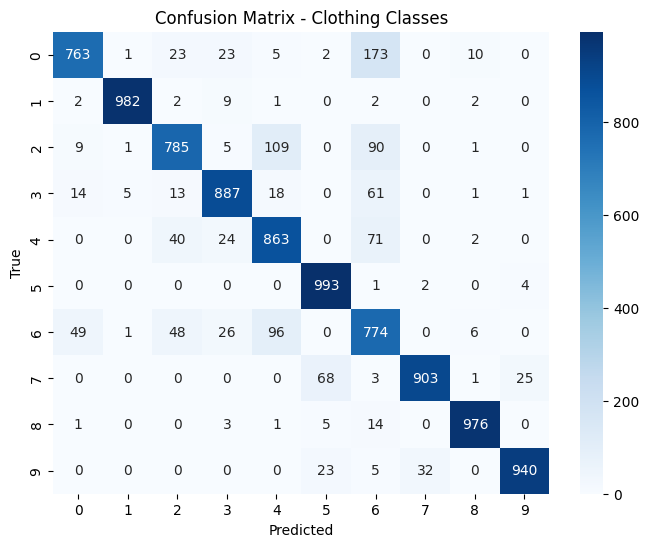

Classification Report - Gender Classes
              precision    recall  f1-score   support

           0       0.29      0.31      0.30      3011
           1       0.30      0.31      0.30      2998
           2       0.39      0.37      0.38      3991

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.33      0.33      0.33     10000



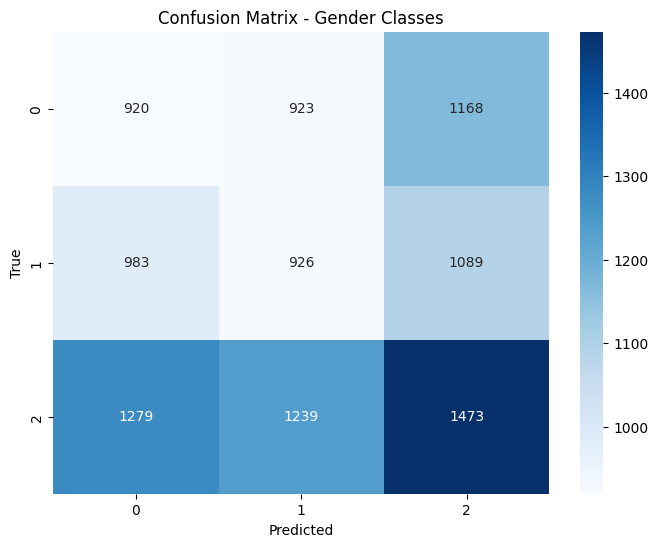

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(scale=np.sqrt(noise_power), size=images.shape)
    return np.clip(images + noise, 0, 1)

def add_salt_and_pepper_noise(images, amount=0.02):
    noisy_images = images.copy()
    num_pixels = int(amount * images.shape[1] * images.shape[2])
    for img in noisy_images:
        coords = [np.random.randint(0, i, num_pixels) for i in img.shape]
        img[coords[0], coords[1]] = np.random.choice([0, 1])
    return noisy_images

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000] / 255.0, X_train_full[-5000:] / 255.0
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train_gaussian = add_gaussian_noise(X_train, snr_db=3)
X_train_sp = add_salt_and_pepper_noise(X_train, amount=0.02)
X_valid_gaussian = add_gaussian_noise(X_valid, snr_db=3)
X_valid_sp = add_salt_and_pepper_noise(X_valid, amount=0.02)

gender_labels = {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 2, 8: 1, 9: 2}
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_valid_gender = np.array([gender_labels[label] for label in y_valid])

input_clean = keras.Input(shape=(28, 28, 1), name="input_clean")
input_gaussian = keras.Input(shape=(28, 28, 1), name="input_gaussian")
input_sp = keras.Input(shape=(28, 28, 1), name="input_sp")

def autoencoder_block(input_layer):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return encoded

encoded_clean = autoencoder_block(input_clean)
encoded_gaussian = autoencoder_block(input_gaussian)
encoded_sp = autoencoder_block(input_sp)

merged = layers.Concatenate()([encoded_clean, encoded_gaussian, encoded_sp])

def decoder_block(encoded_input):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output_reconstructed")(x)
    return decoded

output_reconstructed = decoder_block(merged)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merged)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

output_class = layers.Dense(10, activation='softmax', name="output_class")(x)
output_gender = layers.Dense(3, activation='softmax', name="output_gender")(x)

model = keras.Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[output_class, output_gender, output_reconstructed])

model.compile(optimizer='adam',
              loss={'output_class': 'sparse_categorical_crossentropy', 'output_gender': 'sparse_categorical_crossentropy', 'output_reconstructed': 'mse'},
              metrics={'output_class': 'accuracy', 'output_gender': 'accuracy', 'output_reconstructed': 'mse'})

model.summary()

# Entrenamiento del modelo
history = model.fit([X_train, X_train_gaussian, X_train_sp], [y_train, y_train_gender, X_train],
                    epochs=30, batch_size=128, validation_data=([X_valid, X_valid_gaussian, X_valid_sp], [y_valid, y_valid_gender, X_valid]))

# Evaluación del modelo
y_pred_class, y_pred_gender, _ = model.predict([X_test, add_gaussian_noise(X_test, snr_db=3), add_salt_and_pepper_noise(X_test, amount=0.02)])
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)

# Matrices de confusión y reportes de clasificación
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

print("Classification Report - Clothing Classes")
print(classification_report(y_test, y_pred_class))
plot_confusion_matrix(y_test, y_pred_class, "Confusion Matrix - Clothing Classes")

print("Classification Report - Gender Classes")
print(classification_report(y_train_gender[:len(y_pred_gender)], y_pred_gender))
plot_confusion_matrix(y_train_gender[:len(y_pred_gender)], y_pred_gender, "Confusion Matrix - Gender Classes")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_clean (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gaussian            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sp (InputLayer)     │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_clean[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_gaussian[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_sp[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_36          │ (None, 14, 14, 32)     │              0 │ conv2d_48[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_38          │ (None, 14, 14, 32)     │              0 │ conv2d_50[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_40          │ (None, 14, 14, 32)     │              0 │ conv2d_52[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_36[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_38[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_40[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_37          │ (None, 7, 7, 64)       │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_39          │ (None, 7, 7, 64)       │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_41          │ (None, 7, 7, 64)       │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 7, 7, 192)      │              0 │ max_pooling2d_37[0][0… │
│ (Concatenate)        

 Total params: 1,211,790 (4.62 MB)

 Trainable params: 1,211,790 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 1.1348 - output_class_accuracy: 0.7329 - output_class_loss: 0.7325 - output_gender_accuracy: 0.8407 - output_gender_loss: 0.3711 - output_reconstructed_loss: 0.0312 - output_reconstructed_mse: 0.0312 - val_loss: 0.5078 - val_output_class_accuracy: 0.8794 - val_output_class_loss: 0.3197 - val_output_gender_accuracy: 0.9300 - val_output_gender_loss: 0.1683 - val_output_reconstructed_loss: 0.0099 - val_output_reconstructed_mse: 0.0098
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.4652 - output_class_accuracy: 0.8896 - output_class_loss: 0.3048 - output_gender_accuracy: 0.9427 - output_gender_loss: 0.1512 - output_reconstructed_loss: 0.0091 - output_reconstructed_mse: 0.0091 - val_loss: 0.3912 - val_output_class_accuracy: 0.9042 - val_output_class_loss: 0.2504 - val_output_gender_accuracy: 0.9490 - val_output_gender_loss: 0.1252 - val_output_reconstructed_loss: 0.0072 - val_output_reconstructed_mse: 0.0072
Epoch

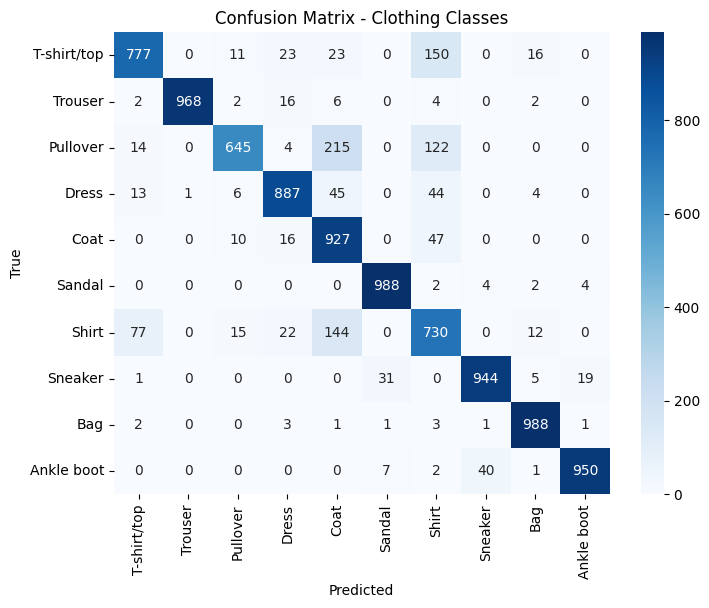

Classification Report - Gender Classes
              precision    recall  f1-score   support

   Masculino       0.29      0.31      0.30      3011
    Femenino       0.30      0.31      0.31      2998
      Neutro       0.40      0.37      0.38      3991

    accuracy                           0.33     10000
   macro avg       0.33      0.33      0.33     10000
weighted avg       0.34      0.33      0.33     10000



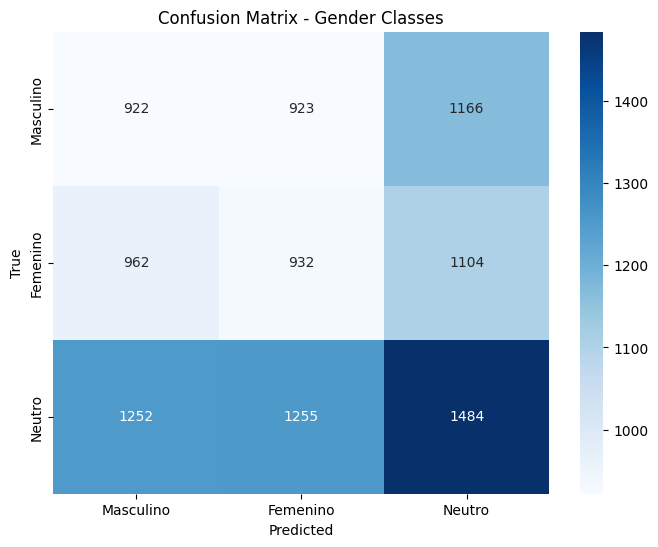

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(scale=np.sqrt(noise_power), size=images.shape)
    return np.clip(images + noise, 0, 1)

def add_salt_and_pepper_noise(images, amount=0.02):
    noisy_images = images.copy()
    num_pixels = int(amount * images.shape[1] * images.shape[2])
    for img in noisy_images:
        coords = [np.random.randint(0, i, num_pixels) for i in img.shape]
        img[coords[0], coords[1]] = np.random.choice([0, 1])
    return noisy_images

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000] / 255.0, X_train_full[-5000:] / 255.0
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train_gaussian = add_gaussian_noise(X_train, snr_db=3)
X_train_sp = add_salt_and_pepper_noise(X_train, amount=0.02)
X_valid_gaussian = add_gaussian_noise(X_valid, snr_db=3)
X_valid_sp = add_salt_and_pepper_noise(X_valid, amount=0.02)

gender_labels = {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 2, 8: 1, 9: 2}
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_valid_gender = np.array([gender_labels[label] for label in y_valid])

input_clean = keras.Input(shape=(28, 28, 1), name="input_clean")
input_gaussian = keras.Input(shape=(28, 28, 1), name="input_gaussian")
input_sp = keras.Input(shape=(28, 28, 1), name="input_sp")

def autoencoder_block(input_layer):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return encoded

encoded_clean = autoencoder_block(input_clean)
encoded_gaussian = autoencoder_block(input_gaussian)
encoded_sp = autoencoder_block(input_sp)

merged = layers.Concatenate()([encoded_clean, encoded_gaussian, encoded_sp])

def decoder_block(encoded_input):
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="output_reconstructed")(x)
    return decoded

output_reconstructed = decoder_block(merged)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merged)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

output_class = layers.Dense(10, activation='softmax', name="output_class")(x)
output_gender = layers.Dense(3, activation='softmax', name="output_gender")(x)

model = keras.Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[output_class, output_gender, output_reconstructed])

model.compile(optimizer='adam',
              loss={'output_class': 'sparse_categorical_crossentropy', 'output_gender': 'sparse_categorical_crossentropy', 'output_reconstructed': 'mse'},
              metrics={'output_class': 'accuracy', 'output_gender': 'accuracy', 'output_reconstructed': 'mse'})

model.summary()

# Entrenamiento del modelo
history = model.fit([X_train, X_train_gaussian, X_train_sp], [y_train, y_train_gender, X_train],
                    epochs=10, batch_size=128, validation_data=([X_valid, X_valid_gaussian, X_valid_sp], [y_valid, y_valid_gender, X_valid]))

# Evaluación del modelo
y_pred_class, y_pred_gender, _ = model.predict([X_test, add_gaussian_noise(X_test, snr_db=3), add_salt_and_pepper_noise(X_test, amount=0.02)])
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)

# Etiquetas para Fashion MNIST
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
gender_labels = ["Masculino", "Femenino", "Neutro"]

# Matrices de confusión y reportes de clasificación
def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

print("Classification Report - Clothing Classes")
print(classification_report(y_test, y_pred_class, target_names=class_labels))
plot_confusion_matrix(y_test, y_pred_class, "Confusion Matrix - Clothing Classes", class_labels)

print("Classification Report - Gender Classes")
print(classification_report(y_train_gender[:len(y_pred_gender)], y_pred_gender, target_names=gender_labels))
plot_confusion_matrix(y_train_gender[:len(y_pred_gender)], y_pred_gender, "Confusion Matrix - Gender Classes", gender_labels)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def add_gaussian_noise(images, snr_db):
    signal_power = np.mean(images ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(scale=np.sqrt(noise_power), size=images.shape)
    return np.clip(images + noise, 0, 1)

def add_salt_and_pepper_noise(images, amount=0.02):
    noisy_images = images.copy()
    num_pixels = int(amount * images.shape[1] * images.shape[2])
    for img in noisy_images:
        coords = [np.random.randint(0, i, num_pixels) for i in img.shape]
        img[coords[0], coords[1]] = np.random.choice([0, 1])
    return noisy_images

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000] / 255.0, X_train_full[-5000:] / 255.0
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train_gaussian = add_gaussian_noise(X_train, snr_db=3)
X_train_sp = add_salt_and_pepper_noise(X_train, amount=0.02)
X_valid_gaussian = add_gaussian_noise(X_valid, snr_db=3)
X_valid_sp = add_salt_and_pepper_noise(X_valid, amount=0.02)

gender_labels = {0: 2, 1: 2, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 2, 8: 1, 9: 2}
y_train_gender = np.array([gender_labels[label] for label in y_train])
y_valid_gender = np.array([gender_labels[label] for label in y_valid])

input_clean = keras.Input(shape=(28, 28, 1), name="input_clean")
input_gaussian = keras.Input(shape=(28, 28, 1), name="input_gaussian")
input_sp = keras.Input(shape=(28, 28, 1), name="input_sp")

def autoencoder_block(input_layer):
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    return encoded

encoded_clean = autoencoder_block(input_clean)
encoded_gaussian = autoencoder_block(input_gaussian)
encoded_sp = autoencoder_block(input_sp)

merged = layers.Concatenate()([encoded_clean, encoded_gaussian, encoded_sp])

def decoder_block(encoded_input):
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = layers.Cropping2D(((2, 2), (2, 2)), name="output_reconstructed")(x)  # Ajuste de tamaño
    return decoded

output_reconstructed = decoder_block(merged)

x_class = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merged)
x_class = layers.Flatten()(x_class)
x_class = layers.Dense(128, activation='relu')(x_class)
output_class = layers.Dense(10, activation='softmax', name="output_class")(x_class)

x_gender = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merged)
x_gender = layers.Flatten()(x_gender)
x_gender = layers.Dense(64, activation='relu')(x_gender)
x_gender = layers.Dropout(0.3)(x_gender)
output_gender = layers.Dense(3, activation='softmax', name="output_gender")(x_gender)

model = keras.Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[output_class, output_gender, output_reconstructed])

model.compile(optimizer='adam',
              loss={'output_class': 'sparse_categorical_crossentropy', 'output_gender': 'sparse_categorical_crossentropy', 'output_reconstructed': 'mse'},
              metrics={'output_class': 'accuracy', 'output_gender': 'accuracy', 'output_reconstructed': 'mse'})

model.summary()

# Entrenamiento del modelo
history = model.fit([X_train, X_train_gaussian, X_train_sp], [y_train, y_train_gender, X_train],
                    epochs=20, batch_size=128, validation_data=([X_valid, X_valid_gaussian, X_valid_sp], [y_valid, y_valid_gender, X_valid]))

# Evaluación del modelo
y_pred_class, y_pred_gender, _ = model.predict([X_test, add_gaussian_noise(X_test, snr_db=3), add_salt_and_pepper_noise(X_test, amount=0.02)])
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)

# Etiquetas para Fashion MNIST
class_labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
gender_labels = ["Masculino", "Femenino", "Neutro"]

# Matrices de confusión y reportes de clasificación
def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

print("Classification Report - Clothing Classes")
print(classification_report(y_test, y_pred_class, target_names=class_labels))
plot_confusion_matrix(y_test, y_pred_class, "Confusion Matrix - Clothing Classes", class_labels)

print("Classification Report - Gender Classes")
print(classification_report(y_train_gender[:len(y_pred_gender)], y_pred_gender, target_names=gender_labels))
plot_confusion_matrix(y_train_gender[:len(y_pred_gender)], y_pred_gender, "Confusion Matrix - Gender Classes", gender_labels)


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_clean (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_gaussian            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sp (InputLayer)     │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_clean[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_gaussian[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 28, 28, 32)     │            320 │ input_sp[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_51          │ (None, 14, 14, 32)     │              0 │ conv2d_71[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_54          │ (None, 14, 14, 32)     │              0 │ conv2d_74[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_57          │ (None, 14, 14, 32)     │              0 │ conv2d_77[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_54[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 14, 14, 64)     │         18,496 │ max_pooling2d_57[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_52          │ (None, 7, 7, 64)       │              0 │ conv2d_72[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_55          │ (None, 7, 7, 64)       │              0 │ conv2d_75[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_58          │ (None, 7, 7, 64)       │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 7, 7, 128)      │         73,856 │ max_pooling2d_52[0][0] │
├──────────────────────

 Total params: 1,806,158 (6.89 MB)

 Trainable params: 1,806,158 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
